In [112]:
import graspy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from src import load_dataset
%matplotlib inline

In [56]:
graphs = load_dataset(parcellation='desikan', preprocess=None, ptr=None)[0]

df = pd.read_csv('../../../../twins/data/raw/unrestricted_jaewonc78_1_20_2019_23_7_58.csv')

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,fMRI_Soc_PctCompl,fMRI_Rel_PctCompl,fMRI_Emo_PctCompl,3T_dMRI_Compl,3T_dMRI_PctCompl,dMRI_3T_ReconVrs,fMRI_3T_ReconVrs,7T_Full_MR_Compl,7T_RS-fMRI_Count,7T_RS-fMRI_PctCompl,7T_Full_Task_fMRI,7T_tMRI_PctCompl,fMRI_Movie_Compl,fMRI_Movie_PctCompl,fMRI_Ret_Compl,fMRI_Ret_PctCompl,7T_dMRI_Compl,7T_dMRI_PctCompl,7T_fMRI_Mov_Vrs,MEG_AnyData,MEG_FullProt_Compl,MEG_HeadModel_Avail,MEG_CortRibn_Avail,MEG_Anatomy_Avail,MEG_Anatomy_Compl,MEG_Noise_Avail,MEG_Noise_Compl,MEG_RS_Avail,MEG_RS_Compl,MEG_WM_Avail,MEG_WM_Compl,MEG_StoryMath_Avail,MEG_StoryMath_Compl,MEG_Motor_Avail,MEG_Motor_Compl,Non-TB_Compl,VisProc_Compl,DelDisc_Compl,SCPT_Compl,IWRD_Compl,PMAT_Compl,VSPLOT_Compl,EmoRecog_Compl,NEO-FFI_Compl,ASR-Syn_Compl,ASR-DSM_Compl,Toolbox_Compl,MMSE_Compl,PSQI_Compl,Alert_Compl,ASQ_Compl,FamPsychNeuro_Compl,SSAGA_Compl,SSAGA_Demo_Compl,SSAGA_Mental_Compl,SSAGA_Alc_Compl,SSAGA_Illicit_Compl,SSAGA_Tob_Compl,SSAGA_Mj_Compl,QC_Issue,MRsession_Scanner_3T,MRsession_Scans_3T,MRsession_Label_3T,MRsession_Scanner_7T,MRsession_Scans_7T,MRsession_Label_7T,MEGsession_Scanner,MEGsession_Scans,MEGsession_Label,Alpha_Peak,Beta_Peak,MMSE_Score,PSQI_Score,PSQI_Comp1,PSQI_Comp2,PSQI_Comp3,PSQI_Comp4,PSQI_Comp5,PSQI_Comp6,PSQI_Comp7,PSQI_BedTime,PSQI_Min2Asleep,PSQI_GetUpTime,PSQI_AmtSleep,PSQI_Latency30Min,PSQI_WakeUp,PSQI_Bathroom,PSQI_Breathe,PSQI_Snore,PSQI_TooCold,...,WM_Task_0bk_Body_Median_RT,WM_Task_0bk_Body_Median_RT_Target,WM_Task_0bk_Body_Median_RT_Nontarget,WM_Task_0bk_Face_Median_RT,WM_Task_0bk_Face_Median_RT_Target,WM_Task_0bk_Face_Median_RT_Nontarget,WM_Task_0bk_Place_Median_RT,WM_Task_0bk_Place_Median_RT_Target,WM_Task_0bk_Place_Median_RT_Nontarget,WM_Task_0bk_Tool_Median_RT,WM_Task_0bk_Tool_Median_RT_Target,WM_Task_0bk_Tool_Median_RT_Nontarget,WM_Task_2bk_Body_Median_RT,WM_Task_2bk_Body_Median_RT_Target,WM_Task_2bk_Body_Median_RT_Nontarget,WM_Task_2bk_Face_Median_RT,WM_Task_2bk_Face_Median_RT_Target,WM_Task_2bk_Face_Median_RT_Nontarget,WM_Task_2bk_Place_Median_RT,WM_Task_2bk_Place_Median_RT_Target,WM_Task_2bk_Place_Median_RT_Nontarget,WM_Task_2bk_Tool_Median_RT,WM_Task_2bk_Tool_Median_RT_Target,WM_Task_2bk_Tool_Median_RT_Nontarget,Endurance_Unadj,Endurance_AgeAdj,GaitSpeed_Comp,Dexterity_Unadj,Dexterity_AgeAdj,Strength_Unadj,Strength_AgeAdj,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E,NEORAW_01,NEORAW_02,NEORAW_03,NEORAW_04,NEORAW_05,NEORAW_06,NEORAW_07,NEORAW_08,NEORAW_09,NEORAW_10,NEORAW_11,NEORAW_12,NEORAW_13,NEORAW_14,NEORAW_15,NEORAW_16,NEORAW_17,NEORAW_18,NEORAW_19,NEORAW_20,NEORAW_21,NEORAW_22,NEORAW_23,NEORAW_24,NEORAW_25,NEORAW_26,NEORAW_27,NEORAW_28,NEORAW_29,NEORAW_30,NEORAW_31,NEORAW_32,NEORAW_33,NEORAW_34,NEORAW_35,NEORAW_36,NEORAW_37,NEORAW_38,NEORAW_39,NEORAW_40,NEORAW_41,NEORAW_42,NEORAW_43,NEORAW_44,NEORAW_45,NEORAW_46,NEORAW_47,NEORAW_48,NEORAW_49,NEORAW_50,NEORAW_51,NEORAW_52,NEORAW_53,NEORAW_54,NEORAW_55,NEORAW_56,NEORAW_57,NEORAW_58,NEORAW_59,NEORAW_60,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,NaN,NaN,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,8,1,2,2,1,1,0,1,09:00:00,30,15:30:00,5.0,2,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.02,119.44,1.31,96.14,83.77,123.48,119.30,27.0,15.0,28.0,24.0,25.0,A,D,SA,SA,N,N,A,A,D,A,A,D,D,A,A,D,N,D,A,A,D,D,A,D,A,A,N,SD,A,A,D,D,N,A,SA,N,N,A,A,A,D,N,D

In [57]:
gender = []
for sub in graphs.keys():
    gender.append(df[df.Subject == int(sub)]['Gender'].values[0])

In [58]:
le = LabelEncoder()
labels = le.fit_transform(gender)
# 1 is male, 0 is female

In [59]:
male_graphs = []
female_graphs = []

for idx, (sub, graph) in enumerate(graphs.items()):
    if labels[idx] == 1:
        male_graphs.append(graph)
    else:
        female_graphs.append(graph)
        
male_graphs = np.array(male_graphs)
female_graphs = np.array(female_graphs)

male_graphs[male_graphs > 0] = 1
female_graphs[female_graphs > 0] = 1

In [60]:
male_graphs_mean = male_graphs.mean(axis=0)
female_graphs_mean = female_graphs.mean(axis=0)

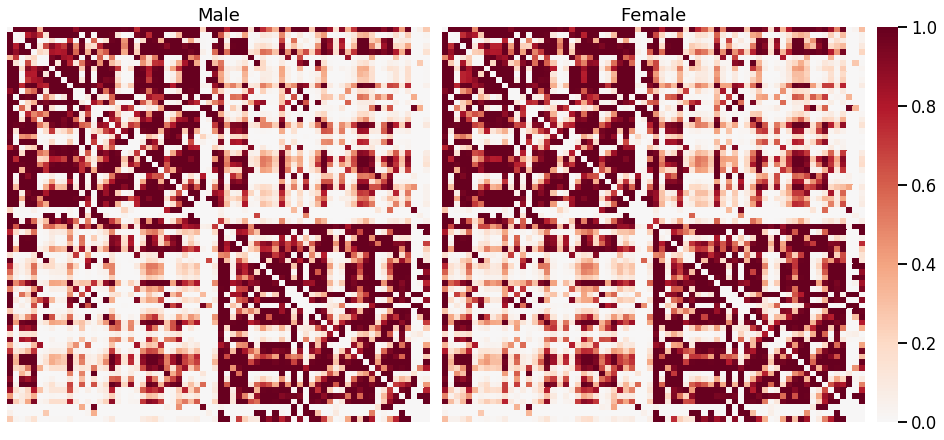

In [118]:
titles = ['Male', 'Female']

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(13, 6),
        ncols=3, 
        gridspec_kw={"width_ratios": [1, 1, 0.05]},
        constrained_layout=True
    )
    for idx, mat in enumerate([male_graphs_mean, female_graphs_mean]):
        sns.heatmap(
            mat, 
            vmin=0,
            vmax=1, 
            cmap='RdBu_r',
            center=0,
            ax = ax[idx],
            cbar_ax = ax[-1],
            xticklabels=False,
            yticklabels=False
        )
        ax[idx].set_title(titles[idx])
        
fig.savefig("./figures/20200301_avg_gender_hcp.png", dpi=300, bbox_inches=False)
fig.savefig("./figures/20200301_avg_gender_hcp.pdf", dpi=300, bbox_inches=False)


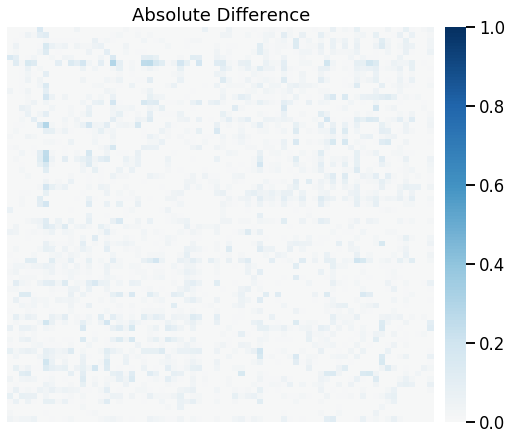

In [122]:
diffs = np.abs(female_graphs_mean - male_graphs_mean)

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(7, 6),
        ncols=2, 
        gridspec_kw={"width_ratios": [1, 0.05]},
        constrained_layout=True
    )
    sns.heatmap(
        diffs, 
        vmin=0,
        vmax=1, 
        cmap='RdBu',
        center=0,
        ax = ax[0],
        cbar_ax = ax[-1],
        xticklabels=False,
        yticklabels=False
    )
    ax[0].set_title("Absolute Difference")
    
fig.savefig("./figures/20200301_abs_diff_gender_hcp.png", dpi=300, bbox_inches=False)
fig.savefig("./figures/20200301_abs_diff_gender_hcp.pdf", dpi=300, bbox_inches=False)

In [74]:
exp_res = pd.read_csv("./20200206_results.csv")

(10100, 15)

In [106]:
diffs = np.abs(female_graphs_mean - male_graphs_mean)
empirical_trustworthiness = np.zeros_like(diffs) 

deltas = exp_res.delta.values
trustworthiness = exp_res.recall_at_10.values

for i in range(diffs.shape[0]):
    for j in range(i + 1, diffs.shape[0]):
        diff = diffs[i, j]
        empirical_delta = np.argmin(np.abs(deltas - diff))
        empirical_trustworthiness[i, j] = trustworthiness[empirical_delta]
        
empirical_trustworthiness = graspy.utils.symmetrize(empirical_trustworthiness, 'triu')

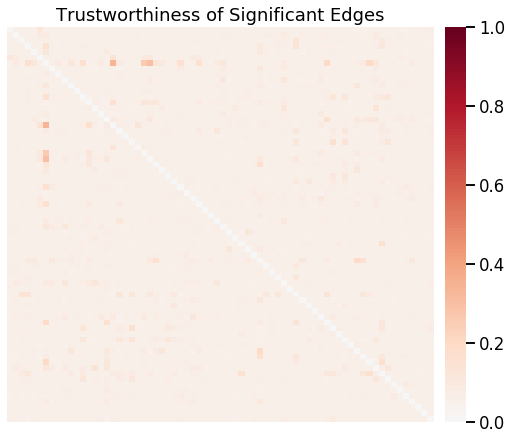

In [123]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(7, 6),
        ncols=2, 
        gridspec_kw={"width_ratios": [1, 0.05]},
        constrained_layout=True
    )
    sns.heatmap(
        empirical_trustworthiness, 
        vmin=0,
        vmax=1, 
        cmap='RdBu_r',
        center=0,
        ax = ax[0],
        cbar_ax = ax[-1],
        xticklabels=False,
        yticklabels=False
    )
    ax[0].set_title("Trustworthiness of Significant Edges")
    
fig.savefig("./figures/20200301_empirical_trustworthiness.png", dpi=300, bbox_inches=False)
fig.savefig("./figures/20200301_empirical_trustworthiness.pdf", dpi=300, bbox_inches=False)